<h1>Northern Pikeminnow Species Distribution Model Comparison</h1>
<h2>Eric Lagally</h2>
<h2>February 2024</h2>
<h3>ericlagally@gmail.com</h3>

The Northern pikeminnow (<i>Ptychocheilus oregonensis</i>) is a freshwater predatory fish native to lakes, streams, and rivers in the Pacific Northwest of the United States. 

![Pikeminnow](pikeminnow1.jpg)


Northern pikeminnow is adaptable to a range of environmental conditions, allowing the species to thrive in human-affected ecosystems.  In particular, its ability to thrive in the face of hydroelectric projects on rivers has made it a common fish in the Snake and Columbia River systems.  This presents a challenge because it preys on salmon fry, and salmon are federally-endangered species.  Thus in order to help salmon survive, there have been bounties placed to incentivize fishing for Northern pikeminnow in multiple rivers. 

To better understand where pikeminnow are likely to occur as a function of environmental conditions and therefore to predict those locations of highest likelihood of salmon predation, I was interested in comparing a number of species distribution models (SDM) for Northern pikeminnow.  

Thanks to the efforts of multiple state and federal agencies, a presence-absence data set is available for multiple fish species, of which Northern pikeminnow is one.  This data set is available through the USGS.[1]  These data can be combined with presence-only observations from GBIF.[2]  Given absence data as a function of geographical location, a variety of both statistical and machine learning SDM approaches are possible.  In cases where such absence data is not available, other approaches including MaxEnt are possible. Although it is also of interest to compare to this approach, the interpretation of presence-absence models is different from presence-only models, so a direct comparison is difficult.

This analysis is based on code from Daniel Fuhrman [3] but extends that work by formatting the data differently, using F1 score, and experimenting with different levels of k-fold cross-validation.  

In [33]:
# import statements
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from pyimpute import load_training_vector, load_targets, impute
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import model_selection
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import glob
import pickle
from scipy import stats
import numpy as np
import seaborn as sns # For pairplots and heatmaps
import matplotlib.pyplot as plot
import os 
from pylab import plt
import rasterio
import warnings
warnings.filterwarnings('ignore')

The first step was to import the USGS dataset and to restrict it to just the observations for this species.  The species list that is included with the data set indicates that the unique identifier for Northern pikeminnow observations is 163523.

In [86]:
# read the data from Google Drive public folder
df = pd.read_csv("https://drive.google.com/uc?export=download&id=13NdUcjLlRgZ61iX-oVZIeOghty929d7x")

In [87]:
# drop all columns except pikeminnow
df = df[["latitude","longitude","163523"]]
df.head()

,latitude,longitude,163523
0,48.860288,-117.378128,False
1,48.646381,-117.370320,True
2,48.596487,-117.350843,False
3,48.534485,-117.301228,True
4,48.463869,-117.306134,False


I also imported the few human-observed occurrences for this species from a GBIF dataset.  There were only 16 such records in the state of Washington (the rest were preserved specimens).

In [88]:
df2 = pd.read_csv("https://drive.google.com/uc?export=download&id=1IeqT6iL_6FRtq3-eBE-fgRGr2yuPIIb8", sep="\t")
df2 = df2[["decimalLatitude","decimalLongitude","basisOfRecord"]]
df2 = df2.rename(columns={"decimalLatitude":"latitude","decimalLongitude":"longitude"})
df2 = df2.loc[df2["basisOfRecord"] == "HUMAN_OBSERVATION"]
df2 = df2[["latitude", "longitude"]]
df2["163523"] = True

In [89]:
df = df.merge(df2,how="outer").reset_index(drop=True)
df

,latitude,longitude,163523
0,45.571959,-122.315684,False
1,45.625254,-122.323395,False
2,45.634880,-122.602426,False
3,45.666945,-122.675462,False
4,45.668695,-122.331910,False
...,...,...,...
551,48.963584,-122.433364,False
552,48.969479,-117.945817,False
553,48.971125,-118.121924,False
554,48.974196,-119.849148,False


I next converted the dataframe I created to a geoPandas dataframe:

In [90]:
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
df2 = df.drop(['longitude', 'latitude'], axis=1)
df2 = df2.rename(columns = {"163523":"CLASS"})
gdf = gpd.GeoDataFrame(df2, crs="EPSG:4326", geometry=geometry)
gdf.head()

,CLASS,geometry
0,False,POINT (-122.31568 45.57196)
1,False,POINT (-122.32339 45.62525)
2,False,POINT (-122.60243 45.63488)
3,False,POINT (-122.67546 45.66694)
4,False,POINT (-122.33191 45.66869)


Some basic descriptive information about the data set:

In [91]:
print("number of duplicates: ", gdf.duplicated(subset='geometry', keep='first').sum())
print("number of NAs: ", gdf['geometry'].isna().sum())
print("Coordinate reference system is: {}".format(gdf.crs))
print("{} observations with {} columns".format(*gdf.shape))

number of duplicates:  0
number of NAs:  0
Coordinate reference system is: EPSG:4326
556 observations with 2 columns


<h2>Environmental Feature Selection</h2>

The environmental variables required some consideration.  I first thought of WorldClim, which provides 19 climatic variables from the years 1970-2000 at a range of different spatial resolutions.  However, it was not clear that these climatic variables would be directly related to habitat suitability for fish.  For instance, precipitation is important in that it affects stream flow, but the stream flow magnitude will depend on specifics of the stream or river, including valley width, gradient, and so on.  If I'm a fish, I don't care how much it's raining, I care how fast my stream is flowing and what this is doing to the streambed.  Likewise, the air temperature isn't important, the water temperature is.  

In the literature some authors use air temperature as a proxy for water temperature and also use thermal amplitude (the difference between minimum and maximum temperatures throughout the year) as a proxy for the thermal variability of oceanic vs. continental climate during the growth periods of fish.[4].  This study also used upstream drainage area and stream power to describe the stream order and size. Other studies point to water velocity, water depth, and sediment size as the variables with the greatest predictive power.[5]  Still other research found that the spatial scale under consideration determined which type of environmental variables were most predictive, geographic or hydro-morphological.[6]

What seems clear is that a combination of geographic and hydro-morphological variables together should be considered.  Given that I was interested in studying fish occurence across Washington state, I made use of data sets that I knew I could readily assess at the degree of spatial resolution that would provide the strongest modeling outcomes.  The NHDPlus dataset from the USGS provides large datasets of stream characteristics, including stream order, stream gradient, stream flow, drainage area, temperature, and elevation.  These are available as vector data sets, which would have to be converted to rasters.

I decided to use stream power, thermal amplitude, mean temperature in July, mean elevation, and drainage area as my environmental features.  Stream power is defined as:

${\Omega} = {\rho}gQS$

where ${\rho}$ is the water density (1000 kg/m$^{3}$), g is the acceleration due to gravity (9.8 m/s$^{2}$), Q is the stream flow rate in m$^{3}$/s, and S is the stream slope.  Thermal amplitude was defined as the mean temperature in January subtracted from the mean temperature in July.  Drainage area was defined in km$^{2}$ and all temperatures were in degrees Celsius.

In [92]:
# grab climate features - cropped to WA state boundary
raster_features = sorted(glob.glob('*Raster.tif'))
# check number of features 
print('\nThere are', len(raster_features), 'raster features.')
print(raster_features)


There are 5 raster features.
['DrainAreaFillRaster.tif', 'JulyMTRaster.tif', 'MeanElevFillRaster.tif', 'StreamPowFillRaster.tif', 'ThermAmpRaster.tif']


In [93]:
train_xs, train_y = load_training_vector(gdf, raster_features, response_field='CLASS')
target_xs, raster_info = load_targets(raster_features)
train_xs.shape, train_y.shape # check shape, does it match the size above of the observations?

((556, 5), (556,))

In [94]:
def splittrains(lists, index):
    temp = []
    for row in lists:
      temp.append(row[index])
    temp = [0.0 if v is None else v for v in temp]
    return temp
    
def remove_nans(list):
    output = []
    count = 0
    for feature in list:
        output.append([0.0 if v is None else v for v in feature])
        count +=1
    return output
    

In [95]:
drainarea = splittrains(train_xs,0)
meantemp = splittrains(train_xs,1)
meanelev = splittrains(train_xs,2)
streampow = splittrains(train_xs,3)
thermamp = splittrains(train_xs,4)
alltogether = [drainarea, meantemp, meanelev, streampow, thermamp]

In [96]:
train_xs = remove_nans(train_xs)

Having extracted samples from the raster features that are the same in number as the observations (556), I next checked to ensure that none of the features are strongly correlated with one another, such that I can minimize covariance and ensure the features are independent of one another. If correlated, these features are likely not linear, so I used Spearman's <i>r</i> instead of the Pearson <i>r</i> to calculate the correlations, becasue Spearman's <i>r</i> is a nonparametric correlation coefficient.  Several studies have used a <i>r</i> > |0.75| or larger correlation coefficient to indicate substantially dependent features, and I use that threshold here as well. [7,8,9]

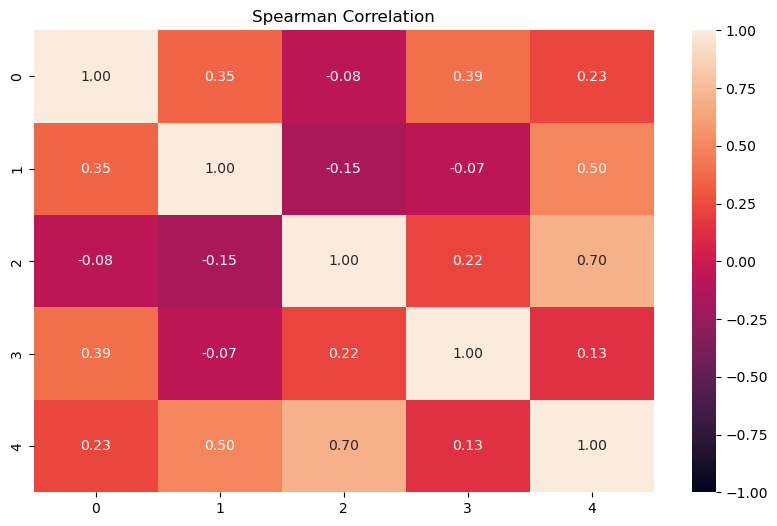

In [97]:
sp = stats.spearmanr(np.transpose(alltogether))[0]
plot.figure(figsize=(10,6))
heatmap = sns.heatmap(sp, vmin=-1, vmax=1, annot=True, fmt="0.2f")
plot.title("Spearman Correlation")
plot.savefig("spearman.png")

Based on these results, none of the 5 features are correlated strongly enough with each other to be discarded.

<h2>Model Fitting</h2>

I set all NaNs to 0 for model training purposes.  Looking at the observation data, although there are 556 observations the vast majority of these are absences (there are only 61 presence points in the data set).  This inbalance of observations makes choosing an accuracy metric especially crucial so as to best reflect the degree of overfitting, the most direct route for which would be the model simply predicting all observations as absences.  This would provide a 93.3% "accuracy" but be a terrible classifier.  Also, based on the limited number of observations overall, k-fold cross-validation will be an important tool to use to avoid overfitting more generally.  However, it is not clear what the best-performing cross-validation level will be. As such, I tested 3-, 4-, and 5-fold cross validation configurations to determine the effect this had on model performance. 

In [110]:

os.mkdir("outputs")

CLASS_MAP = {
    'rf': (RandomForestClassifier()),
    'et': (ExtraTreesClassifier()),
    'xgb': (XGBClassifier()),
    'lgbm': (LGBMClassifier())
    }
scores = pd.DataFrame(columns=["Model Name","k","F1 Score","F1 Standard Deviation","Mean Precision","Mean Recall"])
# model fitting and spatial range prediction
for k in [3,4,5]:
    for name, (model) in CLASS_MAP.items():
    # cross validation for accuracy scores (displayed as a percentage)
    
        kf = model_selection.KFold(n_splits=k)
        accuracy_scores = model_selection.cross_validate(model, train_xs, train_y, cv=kf, scoring=['f1','precision','recall','roc_auc'])
        print(name + " %d-fold Cross Validation F1 score: %0.2f (+/- %0.2f)"
          % (k, accuracy_scores["test_f1"].mean() * 100, accuracy_scores["test_f1"].std() * 200))
        scores.loc[len(scores)] = [name,k, accuracy_scores["test_f1"].mean(), accuracy_scores["test_f1"].std(),accuracy_scores["test_precision"].mean(),accuracy_scores["test_recall"].mean()]
        # spatial prediction
        model.fit(train_xs, train_y)
        os.mkdir("outputs/" + name + "-" + str(k) + "-images")
        impute(target_xs, model, raster_info, outdir="outputs/" + name + "-" + str(k) + "-images",
           class_prob=True, certainty=True)


rf 3-fold Cross Validation F1 score: 33.05 (+/- 31.00)
et 3-fold Cross Validation F1 score: 36.82 (+/- 24.65)
xgb 3-fold Cross Validation F1 score: 32.40 (+/- 9.73)
[LightGBM] [Info] Number of positive: 38, number of negative: 332
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 620
[LightGBM] [Info] Number of data points in the train set: 370, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.102703 -> initscore=-2.167549
[LightGBM] [Info] Start training from score -2.167549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

<h2>Results</h2>

Having trained and fit all the models, the cross-validation scores are shown below:

In [111]:
scores

,Model Name,k,F1 Score,F1 Standard Deviation,Mean Precision,Mean Recall
0,rf,3,0.330481,0.155023,0.466667,0.302233
1,et,3,0.368210,0.123248,0.454545,0.337321
2,xgb,3,0.324037,0.048669,0.342087,0.311802
3,lgbm,3,0.324369,0.082827,0.346825,0.309410
4,rf,4,0.235592,0.202495,0.479532,0.222712
5,et,4,0.313656,0.132890,0.639517,0.266830
6,xgb,4,0.227970,0.134016,0.362500,0.200490
7,lgbm,4,0.271660,0.133293,0.362121,0.260784
8,rf,5,0.142911,0.162121,0.177778,0.140336
9,et,5,0.132174,0.167752,0.175000,0.121008


The best-performing combination of k-fold cross-validation and model was the Extra Trees with 3-fold cross-validation.  It provided the highest F1 score with the lowest variance.  An averaged species occurence probability map is shown below.  

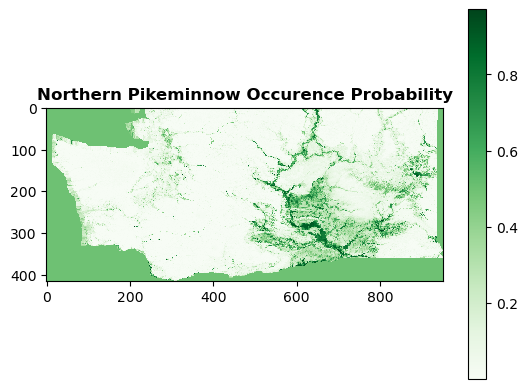

In [112]:
# define spatial plotter
def plotit(x, title, cmap="Blues"):
    plt.imshow(x, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.title(title, fontweight = 'bold')

distr_rf = rasterio.open("outputs/rf-3-images/probability_True.tif").read(1)
distr_et = rasterio.open("outputs/et-3-images/probability_True.tif").read(1)
distr_xgb =  rasterio.open("outputs/xgb-3-images/probability_1.tif").read(1)
distr_lgbm =  rasterio.open("outputs/lgbm-3-images/probability_True.tif").read(1)
distr_averaged = (distr_rf + distr_et + distr_xgb + distr_lgbm)/4  

plotit(distr_averaged, "Northern Pikeminnow Occurence Probability", cmap="Greens")

<h2>Conclusions</h2>

Based on the F1 scores, these results are not fantastic.  The optimal F1 score is 1, reflecting perfect accuracy and perfect recall.  These scores are much lower, a reflection of the fact that we have few overall observations and inbalanced numbers of presence and absence observations.  The precision and recall are both below 50% across all numbers of cross-validation folds.  To increase the F1 score, many more observations would be required, particularly in the presence category.  Somewhat ironically, the Northern Pikeminnow Sport-Reward Program keeps detailed statistics on the pikeminnow catch from various points along the Snake and Columbia River watersheds, totalling thousands of fish a month throughout the spring and summer months every year.[10]  However, without detailed coordinates of the locations of these fish before they were caught, these data cannot be used in this study.  Likewise, the GBIF website shows only 134 observations of northern pikeminnow for the state of Washington, only 26 of which were a live animal and not a preserved specimen.[2]  These 26 observations were included in the study and did increase the balance between presence and absence observations, but only slightly. 

More work is clearly required to record accurate presence and absence data for northern pikeminnow to be able to create a more accurate species distribution model for this species in Washington.

However, the consensus occurence map shows larger probability of pikeminnow presence in those areas where we know pikeminnow currently occur (Snake and Columbia rivers), with larger probability also seen in the rivers that feed these main rivers, the Yakima and Spokane rivers especially.  Small probability of occurence is also present in major rivers in western Washington, notably the Snohomish, Skagit, and to a smaller extent the Nisqually, Cowlitz, White, and Puyallup rivers.



<h2>References</h2>

[1] https://www.usgs.gov/data/presence-absence-database-fish-conterminous-united-states

[2] GBIF.org (16 February 2024) GBIF Occurrence Download https://doi.org/10.15468/dl.sqar36 

[3] https://daniel-furman.github.io/Python-species-distribution-modeling/

[4] https://doi.org/10.1007/s00027-014-0386-z

[5] https://doi.org/10.1007/s00027-015-0413-8

[6] https://doi.org/10.1016/j.ecolmodel.2020.108937

[7] https://doi.org/10.1016/j.limno.2013.12.001

[8] https://doi.org/10.1111/ddi.12086

[9] https://doi.org/10.1038/s41598-023-41406-9

[10] https://www.pikeminnow.org/
